[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/obss/sahi/blob/main/demo/inference_for_yolov5.ipynb)

## 0. Preperation

- Install required libraries

In [ ]:
!pip install -U torch sahi ultralytics onnx onnxruntime

In [1]:
import os
os.getcwd()

'/home/ligirk/workspace/extra/17/sahi'

- Import required modules:

In [1]:
# arrange an instance segmentation model for test
from sahi.utils.yolov8onnx import download_yolov8n_onnx_model

from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image

- Download a yolov8 ONNX model and two test images:

In [ ]:
yolov8_onnx_model_path = "models/yolov8n.onnx"
download_yolov8n_onnx_model(yolov8_onnx_model_path)

# download test images into demo_data folder
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg', 'demo_data/small-vehicles1.jpeg')
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/terrain2.png', 'demo_data/terrain2.png')

## 1. Standard Inference with a YOLOv8 ONNX Model

- Instantiate a detection model by defining model weight path and other parameters:

In [3]:
category_mapping = {'0': 'person','1': 'bicycle','2': 'car','3': 'motorcycle','4': 'airplane','5': 'bus','6': 'train','7': 'truck','8': 'boat','9': 'traffic light','10': 'fire hydrant','11': 'stop sign','12': 'parking meter','13': 'bench','14': 'bird','15': 'cat','16': 'dog','17': 'horse','18': 'sheep','19': 'cow','20': 'elephant','21': 'bear','22': 'zebra','23': 'giraffe','24': 'backpack','25': 'umbrella','26': 'handbag','27': 'tie','28': 'suitcase','29': 'frisbee','30': 'skis','31': 'snowboard','32': 'sports ball','33': 'kite','34': 'baseball bat','35': 'baseball glove','36': 'skateboard','37': 'surfboard','38': 'tennis racket','39': 'bottle','40': 'wine glass','41': 'cup','42': 'fork','43': 'knife','44': 'spoon','45': 'bowl','46': 'banana','47': 'apple','48': 'sandwich','49': 'orange','50': 'broccoli','51': 'carrot','52': 'hot dog','53': 'pizza','54': 'donut','55': 'cake','56': 'chair','57': 'couch','58': 'potted plant','59': 'bed','60': 'dining table','61': 'toilet','62': 'tv','63': 'laptop','64': 'mouse','65': 'remote','66': 'keyboard','67': 'cell phone','68': 'microwave','69': 'oven','70': 'toaster','71': 'sink','72': 'refrigerator','73': 'book','74': 'clock','75': 'vase','76': 'scissors','77': 'teddy bear','78': 'hair drier','79': 'toothbrush'}

In [4]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8onnx',
    model_path=yolov8_onnx_model_path,
    confidence_threshold=0.3,
    category_mapping=category_mapping,
    device="cpu", # or 'cuda:0'
)

- Perform prediction by feeding the get_prediction function with an image path and a DetectionModel instance:

In [5]:
result = get_prediction("demo_data/small-vehicles1.jpeg", detection_model)

- Or perform prediction by feeding the get_prediction function with a numpy image and a DetectionModel instance:

In [6]:
result = get_prediction(read_image("demo_data/small-vehicles1.jpeg"), detection_model)

- Visualize predicted bounding boxes and masks over the original image:

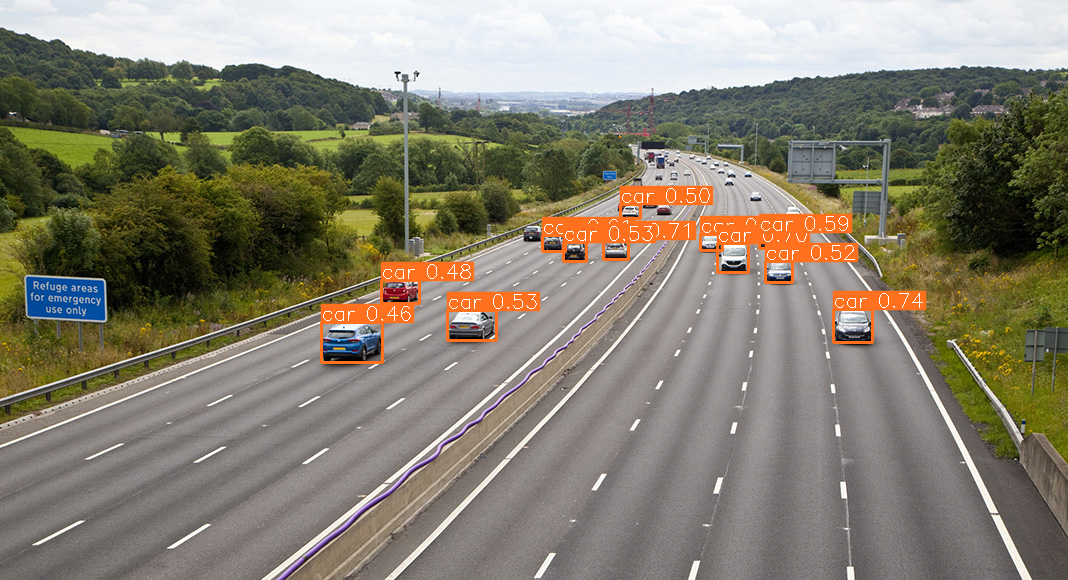

In [7]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 2. Sliced Inference with a YOLOv8 ONNX Model

- To perform sliced prediction we need to specify slice parameters. In this example we will perform prediction over slices of 256x256 with an overlap ratio of 0.2:

In [8]:
result = get_sliced_prediction(
    "demo_data/small-vehicles1.jpeg",
    detection_model,
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2
)

Performing prediction on 15 number of slices.


- Visualize predicted bounding boxes and masks over the original image:

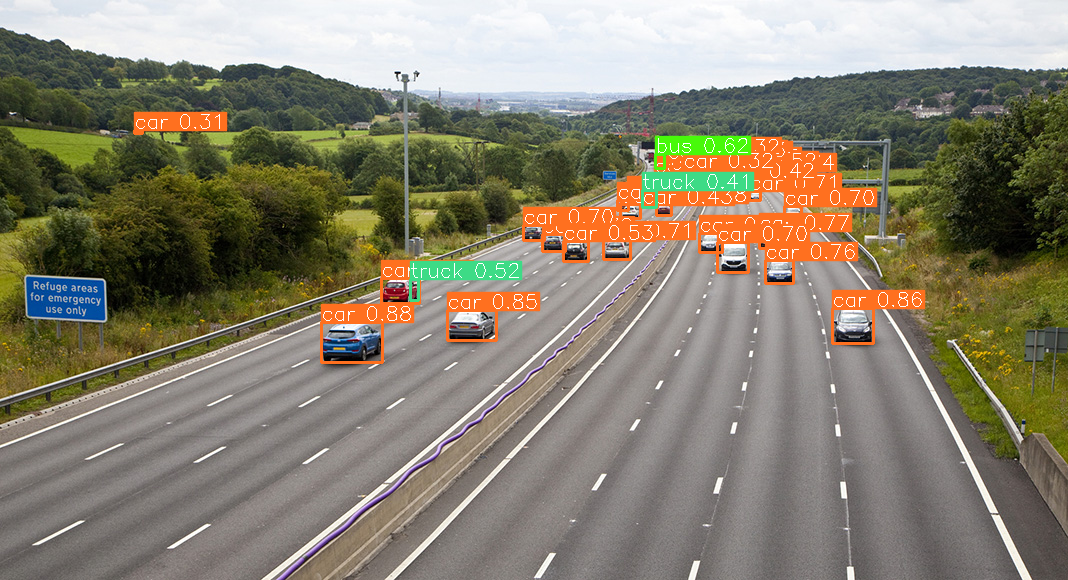

In [9]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 3. Prediction Result

- Predictions are returned as [sahi.prediction.PredictionResult](sahi/prediction.py), you can access the object prediction list as:

In [19]:
object_prediction_list = result.object_prediction_list

In [20]:
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(321.0, 322.0, 382.0, 362.0), w: 61.0, h: 40.0>,
    mask: None,
    score: PredictionScore: <value: 0.8788124322891235>,
    category: Category: <id: 2, name: car>>

- ObjectPrediction's can be converted to [COCO annotation](https://cocodataset.org/#format-data) format:

In [21]:
result.to_coco_annotations()[:3]

[{'image_id': None,
  'bbox': [321.0, 322.0, 61.0, 40.0],
  'score': 0.8788124322891235,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 2440},
 {'image_id': None,
  'bbox': [832.0, 308.0, 41.0, 35.0],
  'score': 0.8613072037696838,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1435},
 {'image_id': None,
  'bbox': [447.0, 310.0, 49.0, 30.0],
  'score': 0.8510035276412964,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1470}]

- ObjectPrediction's can be converted to [COCO prediction](https://github.com/i008/COCO-dataset-explorer) format:

In [22]:
result.to_coco_predictions(image_id=1)[:3]

[{'image_id': 1,
  'bbox': [321.0, 322.0, 61.0, 40.0],
  'score': 0.8788124322891235,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 2440},
 {'image_id': 1,
  'bbox': [832.0, 308.0, 41.0, 35.0],
  'score': 0.8613072037696838,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1435},
 {'image_id': 1,
  'bbox': [447.0, 310.0, 49.0, 30.0],
  'score': 0.8510035276412964,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1470}]

- ObjectPrediction's can be converted to [imantics](https://github.com/jsbroks/imantics) annotation format:

In [23]:
result.to_imantics_annotations()[:3]

- ObjectPrediction's can be converted to [fiftyone](https://github.com/voxel51/fiftyone) detection format:

In [ ]:
result.to_fiftyone_detections()[:3]

## 4. Batch Prediction

- Set model and directory parameters:

In [17]:
model_type = "yolov8onnx"
model_path = yolov8_onnx_model_path
model_device = "cpu" # or 'cuda:0'
model_confidence_threshold = 0.4
model_category_mapping = category_mapping

slice_height = 256
slice_width = 256
overlap_height_ratio = 0.2
overlap_width_ratio = 0.2

source_image_dir = "demo_data/"

- Perform sliced inference on given folder:

In [18]:
predict(
    model_type=model_type,
    model_path=model_path,
    model_device=model_device,
    model_confidence_threshold=model_confidence_threshold,
    model_category_mapping=model_category_mapping,
    source=source_image_dir,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_height_ratio,
    overlap_width_ratio=overlap_width_ratio,
)

There are 3 listed files in folder: demo_data/


Performing inference on images:   0%|                                                         | 0/3 [00:00<?, ?it/s]

Performing prediction on 20 number of slices.


Performing inference on images:  33%|████████████████▎                                | 1/3 [00:00<00:01,  1.04it/s]

Prediction time is: 928.90 ms
Performing prediction on 15 number of slices.


Performing inference on images:  67%|████████████████████████████████▋                | 2/3 [00:01<00:00,  1.20it/s]

Prediction time is: 709.63 ms
Performing prediction on 15 number of slices.


Performing inference on images: 100%|█████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s]

Prediction time is: 683.21 ms
Prediction results are successfully exported to runs/predict/exp4
